In [9]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from math import sqrt
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import seaborn as sns

In [10]:
mpl.rcParams.update({
    "font.family":        "sans-serif",
    "font.sans-serif":    ["Arial"],
    "font.size":          12.0,   # global
    "axes.titlesize":     12.0,   # subplot title
    "axes.labelsize":     12.0,   # axis labels
    "xtick.labelsize":    11.0,   # tick labels slightly smaller
    "ytick.labelsize":    11.0,
    "legend.fontsize":    9.5,   # legend text

    # axes / ticks
    "axes.linewidth":     0.8,
    "xtick.direction":    "out",
    "ytick.direction":    "out",
    "xtick.major.size":   3.0,
    "xtick.major.width":  0.8,
    "ytick.major.size":   3.0,
    "ytick.major.width":  0.8,
    "xtick.minor.size":   2.0,
    "xtick.minor.width":  0.5,
    "ytick.minor.size":   2.0,
    "ytick.minor.width":  0.5,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.pad":    4,
    "ytick.major.pad":    4,

    # spacing
    "axes.labelpad":      4,
    "axes.titlepad":      6,

    # default line width
    "lines.linewidth":    0.9,

    # no grid by default
    "axes.grid":          False,

    # savefig defaults
    "savefig.dpi":        300,
    "savefig.bbox":       "tight",
})

In [11]:
def mbe(y_true, y_pred):
    """Mean Bias Error (MBE): mean(true - pred)."""
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    valid = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if valid.sum() == 0:
        return np.nan
    return (y_true[valid] - y_pred[valid]).mean()

In [13]:
info = pd.read_excel("./SiteInfo.xlsx")  # expected columns: 'Lat','Lon','Year'

eu_ht, li_ht, eu_wt, li_wt = [], [], [], []

for lat, lon, iyear in zip(info['Lat'], info['Lon'], info['Year']):
    # compute 5x5 region that contains the site (same logic as original)
    reg_slat = (int(lat/5)*5) if lat >= 0 else (int(lat/5)*5 - 5)
    reg_elat = reg_slat + 5
    reg_slon = (int(lon/5)*5) if lon >= 0 else (int(lon/5)*5 - 5)
    reg_elon = reg_slon + 5

    base = f"RG_{reg_elat}_{reg_slon}_{reg_slat}_{reg_elon}"
    nc_path = f'/tera12/yuanhua/mksrf/srf_5x5/{base}.MOD2000.nc'
    if not os.path.exists(nc_path):
        # skip if the region file does not exist
        continue

    # GHSL rooftop dataset (500m)
    ghsl_path = f'/tera12/yuanhua/data/CoLMrawdata/urban_morphology/roof_height_fraction_GHSL/{base}.ROOF500m.GHSL.{iyear}.nc'
    if os.path.exists(ghsl_path):
        ds = xr.open_dataset(ghsl_path)
        i_lat = abs(ds.lat - lat).argmin().item()
        i_lon = abs(ds.lon - lon).argmin().item()
        eu_ht.append(ds['HT_ROOF'][:, :].isel(lat=i_lat, lon=i_lon).values)
        eu_wt.append(ds['PCT_ROOF'][:, :].isel(lat=i_lat, lon=i_lon).values)
        ds.close()
    else:
        # keep consistent lengths by appending NaNs if missing
        eu_ht.append(np.full((1,), np.nan))
        eu_wt.append(np.full((1,), np.nan))

    # Li rooftop dataset (1km)
    li_path = f'/tera12/yuanhua/data/CoLMrawdata/urban_morphology/roof_height_fraction_Li/{base}.ROOF1km.Li.nc'
    if os.path.exists(li_path):
        ds = xr.open_dataset(li_path)
        i_lat = abs(ds.lat - lat).argmin().item()
        i_lon = abs(ds.lon - lon).argmin().item()
        li_ht.append(ds['HT_ROOF'][:, :].isel(lat=i_lat, lon=i_lon).values)
        li_wt.append(ds['PCT_ROOF'][:, :].isel(lat=i_lat, lon=i_lon).values)
        ds.close()
    else:
        li_ht.append(np.full((1,), np.nan))
        li_wt.append(np.full((1,), np.nan))

# Print small check (first few)
print("Sample EU rooftop heights (first entries):", [a if isinstance(a, np.ndarray) else None for a in eu_ht[:3]])

Sample EU rooftop heights (first entries): [array(7.4821053, dtype=float32), array(8.753355, dtype=float32), array(9.757637, dtype=float32)]


In [14]:
# ================== Load OBS and LUT data ==================
obs = np.loadtxt('OBS.txt')   # observations: columns expected per your original code
ncar = np.loadtxt('NCAR.txt')
lcz  = np.loadtxt('LCZ.txt')
site_list = np.loadtxt('site.txt', dtype=str)

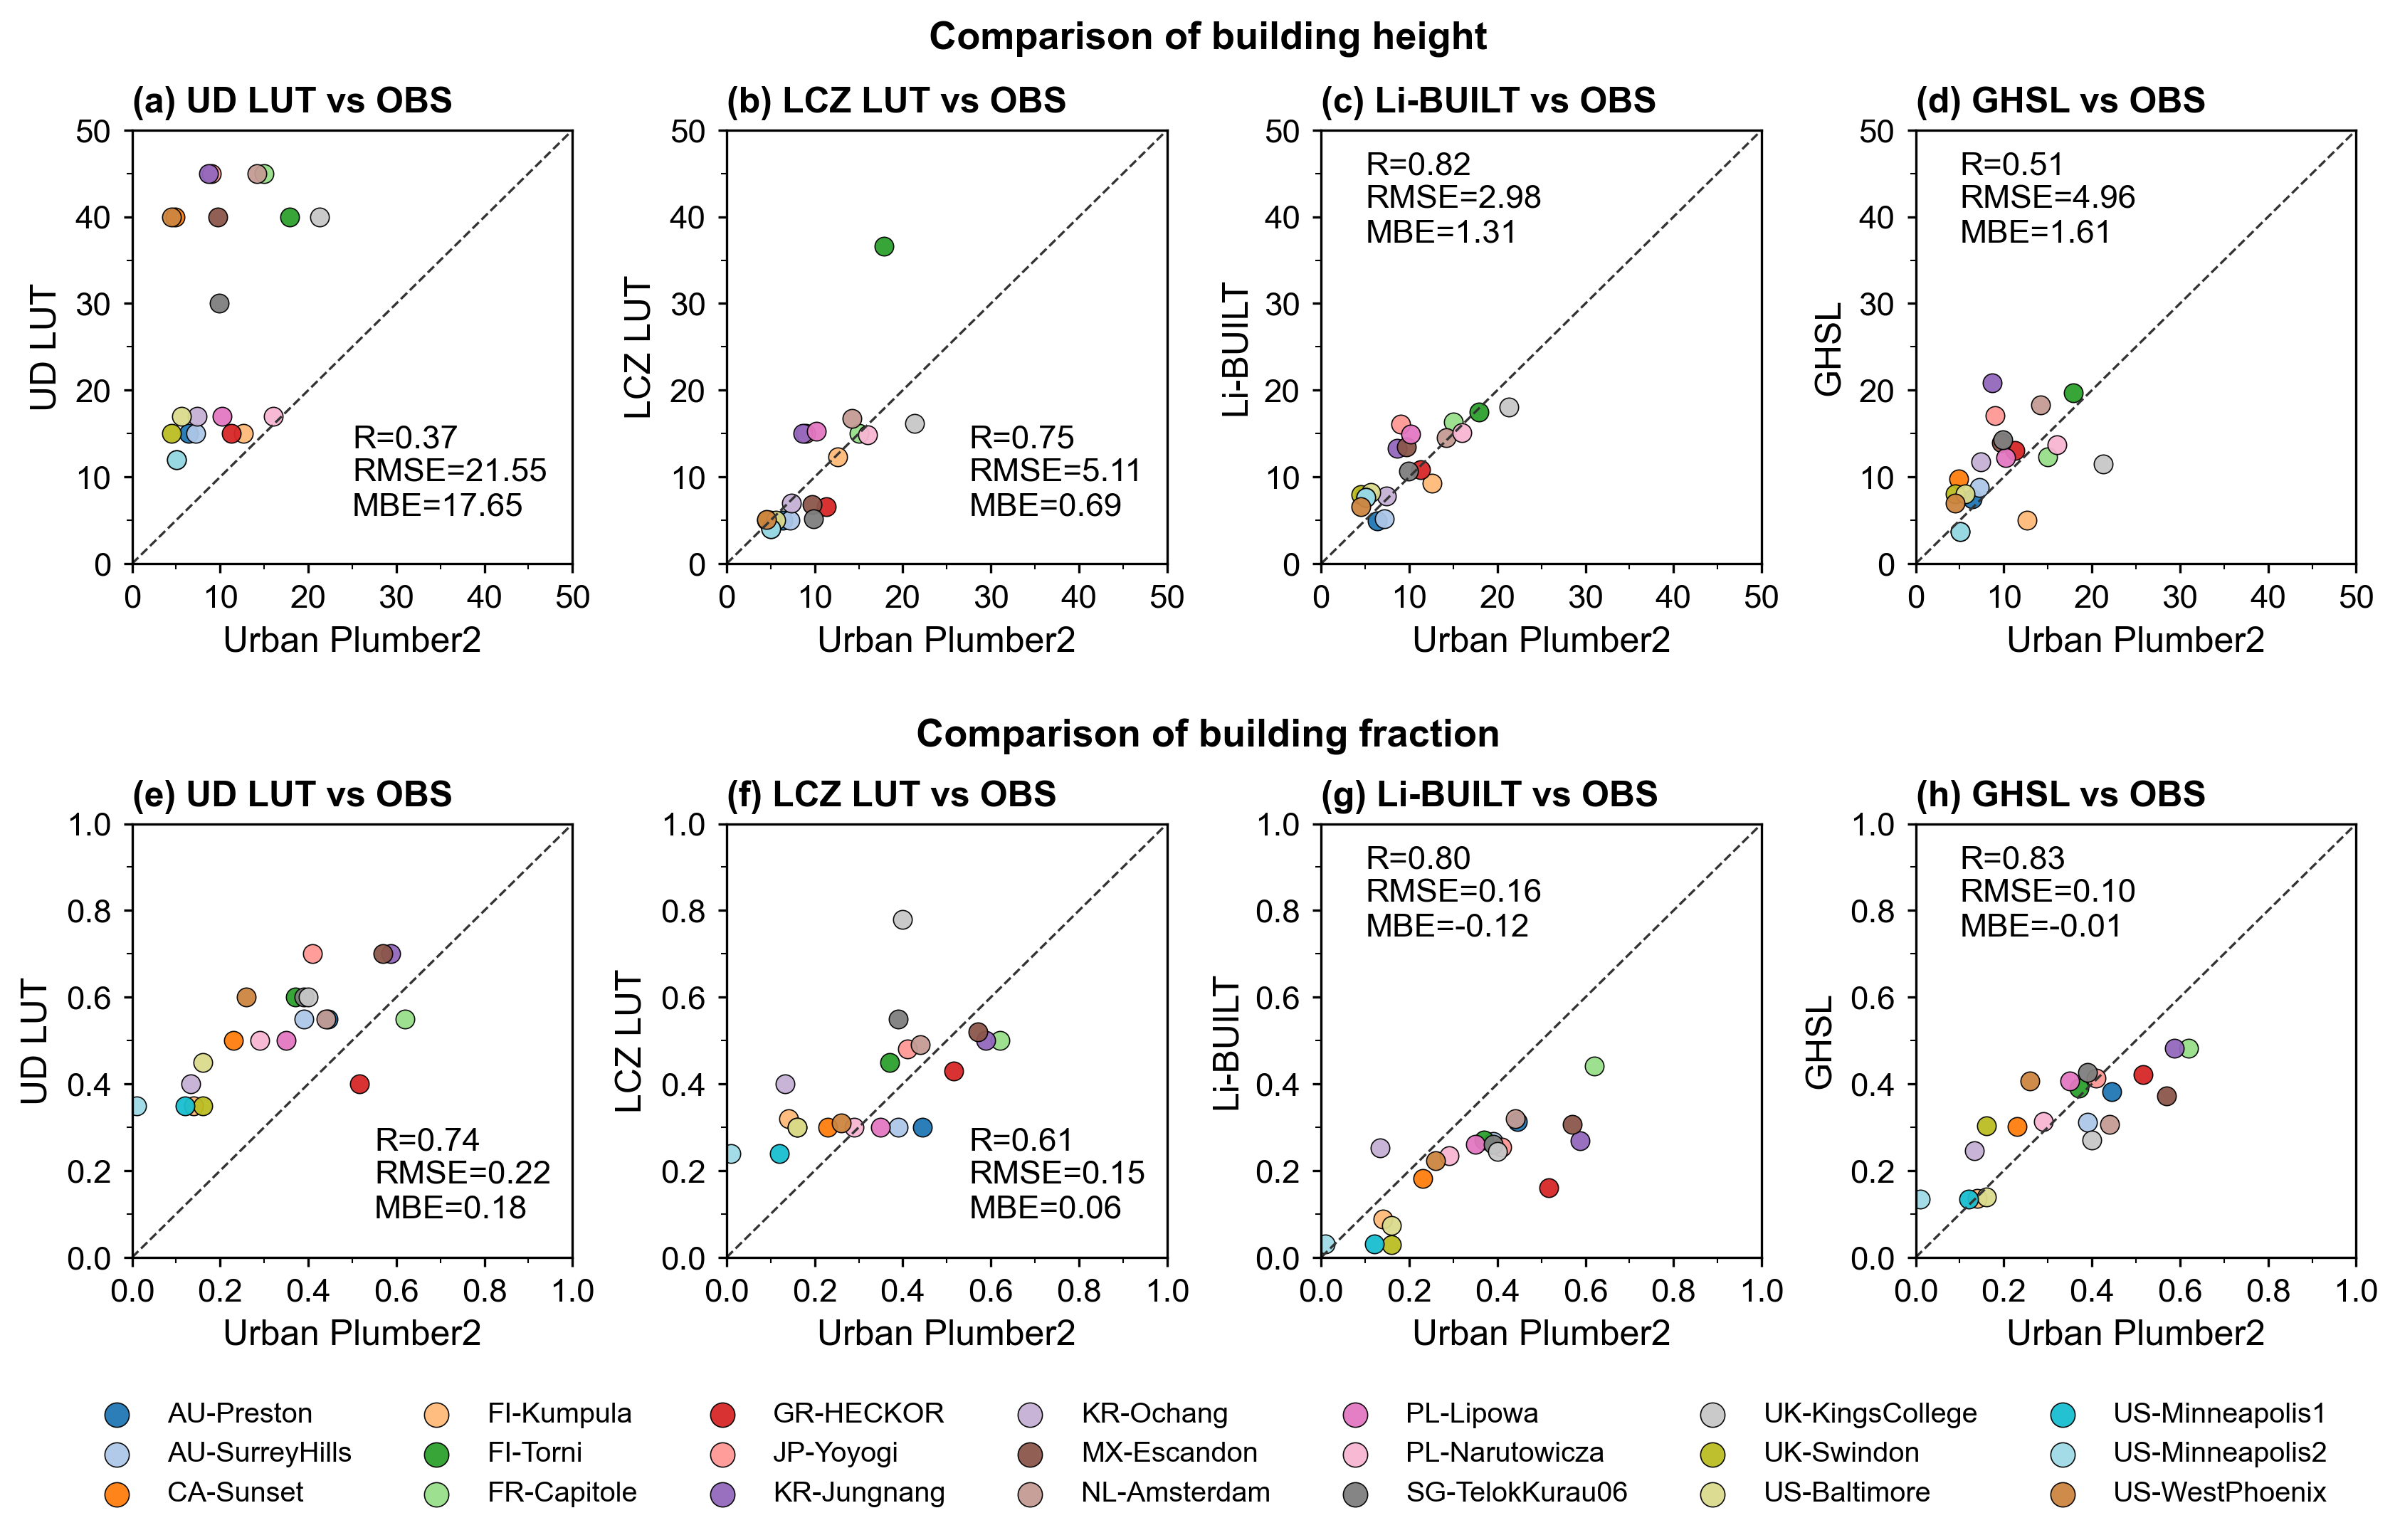

In [15]:
# ================== Plotting parameters for Nature-like figure ==================
# We'll use a color palette with good distinguishability
palette = sns.color_palette("tab20", 20)

# Use smaller marker sizes and moderate linewidths
marker_size = 40      # scatter marker 's' argument (area)
edge_width = 0.4      # marker edge width
alpha_val = 0.95

# ================== Create figure (2 rows x 4 columns) ==================
# Slightly wider figure so labels don't crowd
fig = plt.figure(figsize=(11.2, 6.0), dpi=300)

titles = [
    '(a) UD LUT vs OBS', '(b) LCZ LUT vs OBS', '(c) Li-BUILT vs OBS', '(d) GHSL vs OBS',
    '(e) UD LUT vs OBS', '(f) LCZ LUT vs OBS', '(g) Li-BUILT vs OBS', '(h) GHSL vs OBS'
]

# collect handles for legend (first occurrence per site)
legend_handles = {}
# iterate panels
for idx in range(8):
    ax = plt.subplot(2, 4, idx + 1)

    # choose the predictor arrays and axis limits based on panel row
    if idx < 4:
        pre = [ncar[:, 3], lcz[:, 3], li_ht, eu_ht][idx]
        tar = obs[:, 3]
        lim = (0, 50)
        ticks = np.linspace(0, 50, 6)
        minor = 5
    else:
        pre = [ncar[:, 1], lcz[:, 1], li_wt, eu_wt][idx - 4]
        tar = obs[:, 1]
        lim = (0, 1)
        ticks = np.linspace(0, 1, 6)
        minor = 0.1

    # flatten arrays safely
    pre = np.atleast_1d(np.asarray(pre).flatten())
    tar = np.atleast_1d(np.asarray(tar).flatten())

    # compute simple metrics
    err = tar - pre
    rmse = sqrt(np.nanmean(err**2))
    # handle degenerate correlation
    try:
        corr = np.corrcoef(tar, pre)[0, 1]
    except Exception:
        corr = np.nan

    # scatter points per site: consistent color mapping by index
    for u, s in enumerate(site_list):
        if u < 20:
            color = palette[u % len(palette)]
        else:
            color = 'peru'  # fallback color for extra sites

        # guard if arrays too short or nan
        try:
            x_val = float(tar[u])
            y_val = float(pre[u])
        except Exception:
            continue
        sc = ax.scatter(
            x_val, y_val,
            s=marker_size,
            color=color,
            edgecolor="black",
            lw=edge_width,
            alpha=alpha_val,
            label=s
        )
        # record first-handle for each site (avoid duplicates)
        if s not in legend_handles:
            legend_handles[s] = sc

    # 1:1 reference line
    ax.plot(lim, lim, linestyle='--', color='0.2', linewidth=0.8)

    # axis limits and ticks
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.xaxis.set_minor_locator(MultipleLocator(minor))
    ax.yaxis.set_minor_locator(MultipleLocator(minor))
    ax.tick_params(axis='x', which='major', top=False)
    ax.tick_params(axis='y', which='major', right=False)

    # title and axis labels (left-aligned title)
    ax.set_title(titles[idx], loc='left', fontweight='bold')
    ylabel = ['UD LUT', 'LCZ LUT', 'Li-BUILT', 'GHSL'][idx % 4]
    ax.set_ylabel(ylabel)         # inherit rcParams (12pt)
    ax.set_xlabel('Urban Plumber2')# inherit rcParams (12pt)

    # annotation with R, RMSE, MBE
    stats_text = f'R={corr:.2f}\nRMSE={rmse:.2f}\nMBE={mbe(pre, tar):.2f}'
    # place labels to avoid overlap for specific panels (as you had)
    if idx == 0:
        ax.text(0.5, 0.32, stats_text, transform=ax.transAxes, ha='left', va='top', fontsize=11,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.0))
    elif idx == 1:
        ax.text(0.55, 0.32, stats_text, transform=ax.transAxes, ha='left', va='top', fontsize=11,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.0))
    elif idx in (4, 5):
        ax.text(0.55, 0.3, stats_text, transform=ax.transAxes, ha='left', va='top', fontsize=11,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.0))
    else:
        ax.text(0.1, 0.95, stats_text, transform=ax.transAxes, ha='left', va='top', fontsize=11,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.0))

    # thin but visible spines consistent with journal style
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)

# ================== place legend at bottom (combined) ==================
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(),
           loc='lower center', ncol=7, frameon=False,
           bbox_to_anchor=(0.5, -0.115), markerscale=1.3)

# ================== shared titles / layout ==================
fig.suptitle('Comparison of building height', y=1.065, fontsize=13, weight='bold')     # slightly larger for suptitle
fig.text(0.5, 0.5065, "Comparison of building fraction", ha='center', va='center', fontsize=13, weight='bold')

# tighten layout and adjust spacing for multi-panel figure
fig.subplots_adjust(hspace=0.6, wspace=0.35, left=0.05, right=0.98, top=0.98, bottom=0.1)

# save as PDF
plt.savefig('Figure2.pdf', dpi=300, bbox_inches='tight')